In [1]:
!pip install investpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 18.7 MB/s eta 0:00:00
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481568 sha256=1d8a26e11b82fa2b8e4ea847ee00ec03b69512251cde58355ccc464f248620e2
  Stored in directory: /root/.cache/pip/wheels/db/f4/ae/980b93b0257620bc8e4afc98a854a7a746a33eb8335fd07906
Successfully built investpy


In [2]:
!pip install tensorflow

In [184]:
import investpy
import pandas as pd
import requests
from pandas import json_normalize
import time
from datetime import datetime, timedelta
import numpy as np
from pandas.plotting import lag_plot

import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
# Draw chart
import matplotlib.pyplot as plt

#LSTM
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM ,Bidirectional , GRU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import RepeatVector, TimeDistributed
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # đo phần trăm sai số tuyệt đối trung bình
from sklearn.metrics import mean_squared_error # đo sai số trung bình bình phương


In [4]:
def stock_historical_data (symbol, start_date, end_date, resolution): #
    headers = {
  'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
  'Accept-Language': 'en-GB,en-US;q=0.9,en;q=0.8,vi;q=0.7',
  'Cache-Control': 'max-age=0',
  'Connection': 'keep-alive',
  'Cookie': 'vnds-uuid=25405970-2bce-4dce-9549-c49bf930276a; vnds-uuid-d=1686109429540; _gid=GA1.3.1599710538.1687624546; _ga=GA1.1.983248131.1686109430; _ga_E9VQ08SM6F=GS1.1.1687624545.2.1.1687626022.60.0.0',
  'Sec-Fetch-Dest': 'document',
  'Sec-Fetch-Mode': 'navigate',
  'Sec-Fetch-Site': 'none',
  'Sec-Fetch-User': '?1',
  'Upgrade-Insecure-Requests': '1',
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
  'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"'
}
    from_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    to_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
    url = f"https://dchart-api.vndirect.com.vn/dchart/history?resolution={resolution}&symbol={symbol}&from={from_timestamp}&to={to_timestamp}"
    response = requests.request("GET", url, headers=headers).json()
    df = pd.DataFrame(response)
    df['t'] = pd.to_datetime(df['t'], unit='s')
    df = df.rename(columns={'t': 'time', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}).drop(columns=['s'])
    return df

In [55]:
df = stock_historical_data("GAS", "2020-01-01", "2024-04-28", resolution="D")

In [56]:
df

,time,close,open,high,low,volume
0,2020-01-02,68.444,67.793,68.878,67.793,141260
1,2020-01-03,68.588,68.444,69.746,68.444,218980
2,2020-01-06,70.759,69.963,70.904,69.601,431090
3,2020-01-07,70.252,70.687,70.687,69.674,142800
4,2020-01-08,70.180,71.338,71.627,70.180,439260
...,...,...,...,...,...,...
1073,2024-04-22,75.000,75.200,75.600,74.900,820000
1074,2024-04-23,74.200,75.500,75.500,74.000,474500
1075,2024-04-24,74.600,75.000,75.000,74.300,852300
1076,2024-04-25,74.000,74.600,74.900,74.000,788500


In [9]:
df.columns.tolist()

['time', 'close', 'open', 'high', 'low', 'volume']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    327 non-null    datetime64[ns]
 1   close   327 non-null    float64       
 2   open    327 non-null    float64       
 3   high    327 non-null    float64       
 4   low     327 non-null    float64       
 5   volume  327 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 15.5 KB


In [57]:
df.describe()

,time,close,open,high,low,volume
count,1078,1078.000000,1078.000000,1078.000000,1078.000000,1.078000e+03
mean,2022-02-28 21:17:01.892393216,74.295397,74.411903,75.386906,73.400509,7.966443e+05
min,2020-01-02 00:00:00,38.997000,39.576000,40.082000,38.997000,7.350000e+04
25%,2021-01-27 06:00:00,65.346000,65.289000,66.047750,64.587000,4.172275e+05
50%,2022-03-02 12:00:00,76.500000,76.581000,77.414500,75.882000,6.402550e+05
75%,2023-03-29 18:00:00,84.604000,84.986250,86.120000,83.639000,9.993500e+05
max,2024-04-26 00:00:00,104.909000,102.561000,104.909000,100.447000,4.515800e+06
std,NaN,13.220393,13.245913,13.526574,12.973200,5.635447e+05


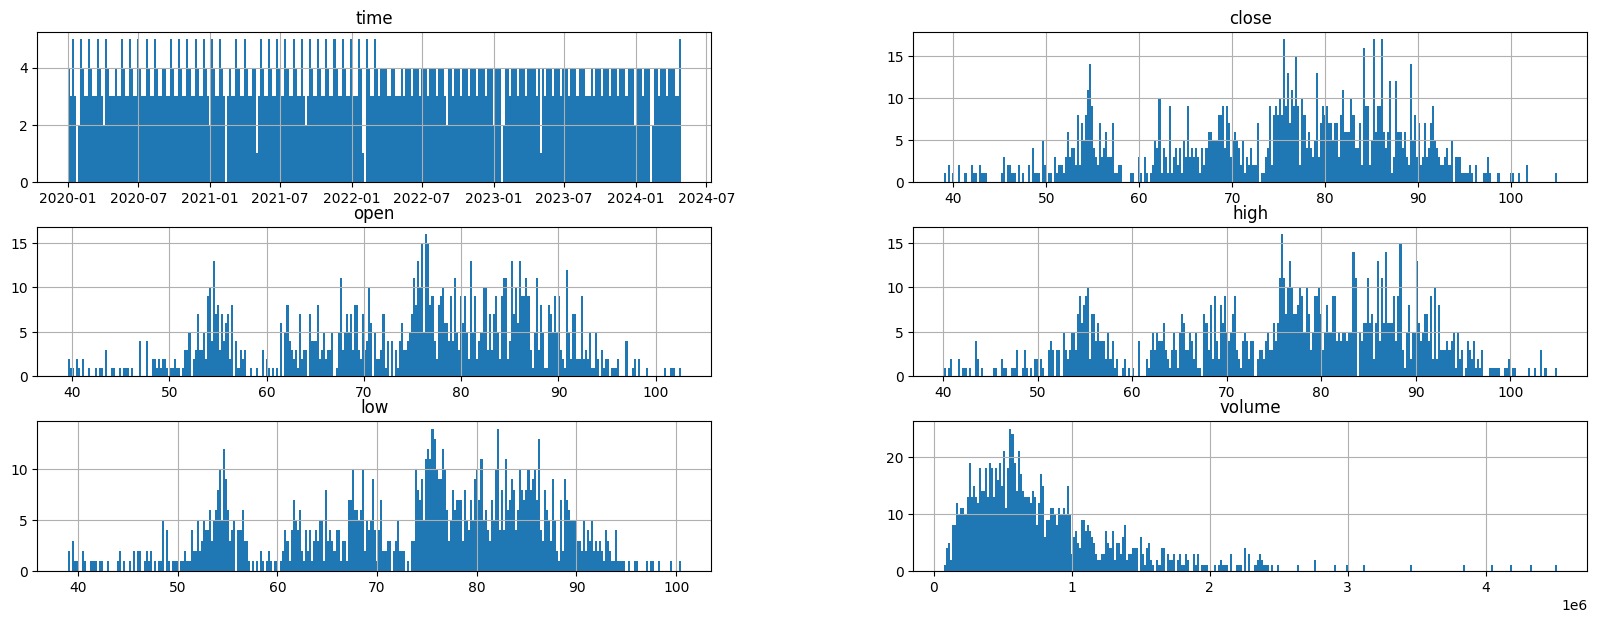

In [58]:
df.hist(bins = 300)
plt.gcf().set_size_inches(20, 7)
plt.show()

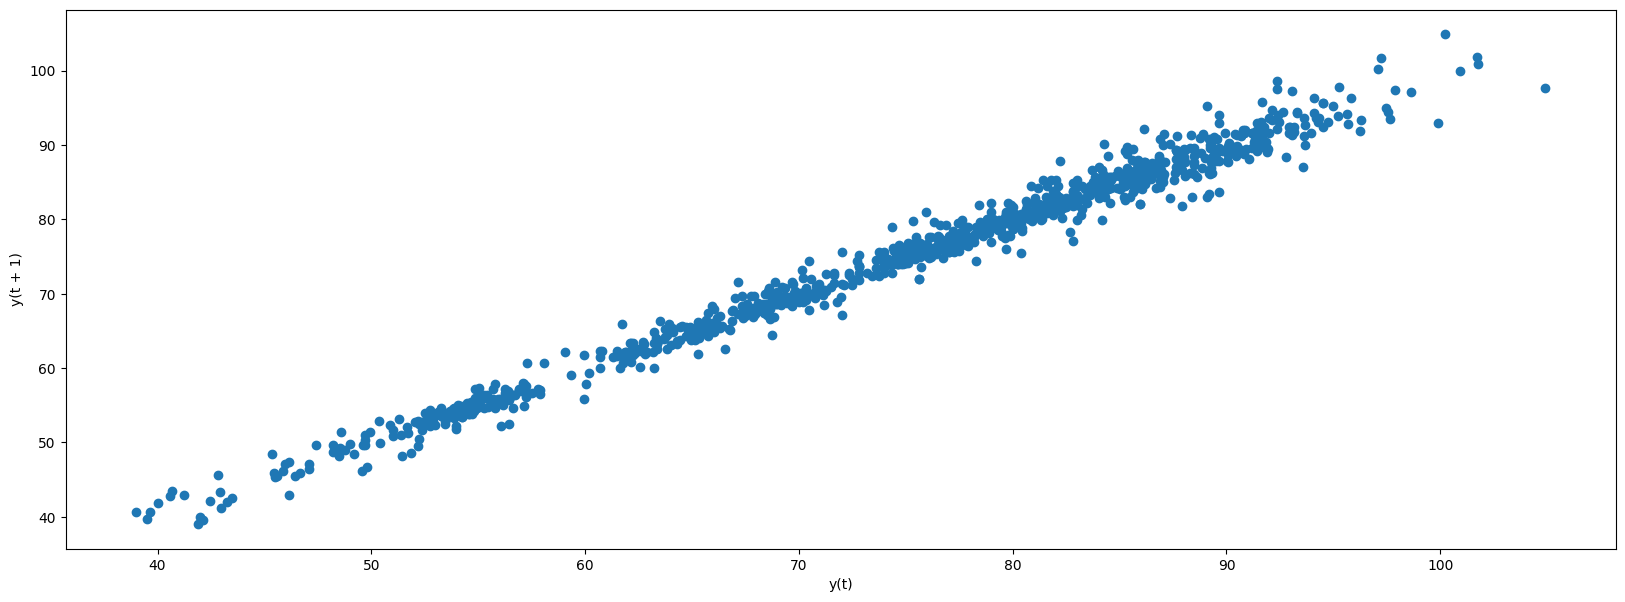

In [59]:
plt.figure(figsize=(20, 7))
lag_plot(df['close'])
plt.show()

<Figure size 1800x600 with 0 Axes>

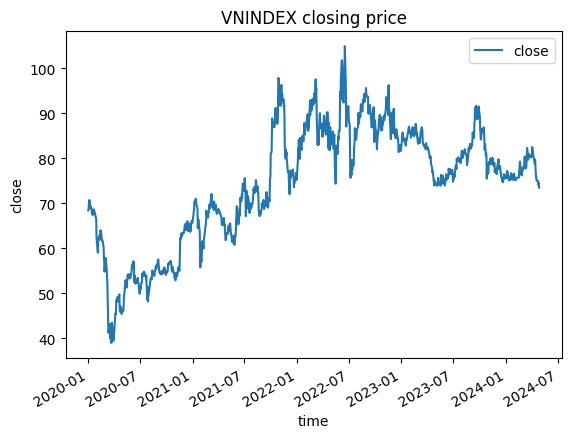

In [60]:
plt.figure(figsize=(18, 6))
df.plot('time' , 'close')
plt.xlabel('time')
plt.ylabel('close')
plt.title('VNINDEX closing price')
plt.show()

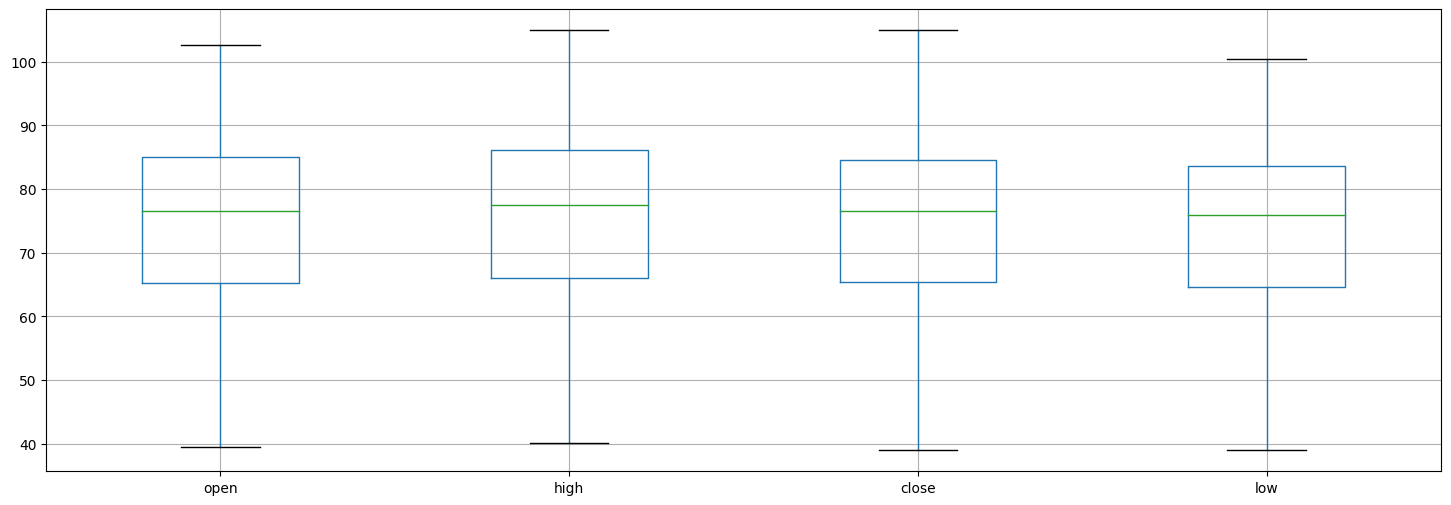

In [61]:
plt.figure(figsize=(18, 6))
df[['open','high' , 'close','low']].boxplot()
plt.show()

In [62]:

df['50 day'] = df['close'].rolling(window=50).mean()
df['200 day'] = df['close'].rolling(window=200).mean()


In [63]:
df.iloc[:100 , :]

,time,close,open,high,low,volume,50 day,200 day
0,2020-01-02,68.444,67.793,68.878,67.793,141260,NaN,NaN
1,2020-01-03,68.588,68.444,69.746,68.444,218980,NaN,NaN
2,2020-01-06,70.759,69.963,70.904,69.601,431090,NaN,NaN
3,2020-01-07,70.252,70.687,70.687,69.674,142800,NaN,NaN
4,2020-01-08,70.180,71.338,71.627,70.180,439260,NaN,NaN
...,...,...,...,...,...,...,...,...
95,2020-05-26,54.191,53.901,54.191,53.395,615970,47.07280,NaN
96,2020-05-27,54.263,54.625,55.204,54.118,1141480,47.33326,NaN
97,2020-05-28,53.467,54.263,54.552,53.467,551210,47.54452,NaN
98,2020-05-29,53.829,53.901,53.901,53.322,372610,47.75578,NaN


<Figure size 1800x600 with 0 Axes>

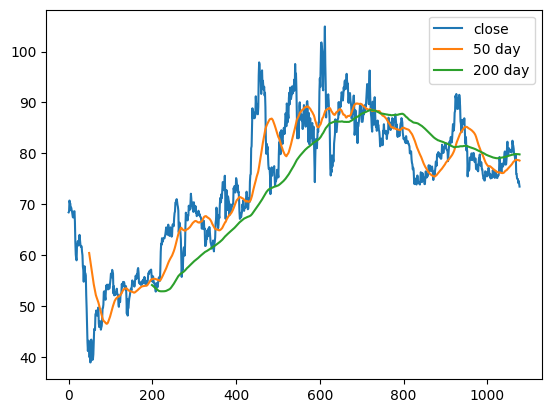

In [64]:
plt.figure(figsize=(18, 6))
df[['close','50 day' , '200 day']].plot()
plt.show()

In [68]:
actual_50 = df['close'].iloc[50:].values
predicted_50 = df['50 day'].iloc[50:].values

In [66]:
actual_200 = df['close'].iloc[200:].values
predicted_200 = df['200 day'].iloc[200:].values

In [70]:
# đánh giá mae và rsme
rmse_sma = np.sqrt(mean_squared_error(actual_50, predicted_50))  # Tính RMSE
mae_sma = mean_absolute_error(actual_50, predicted_50 )  # Tính MAE

# In ra kết quả
print(f"Root Mean Squared Error (RMSE) of SMA_50: {rmse_sma}")
print(f"Mean Absolute Error (MAE) of SMA_50: {mae_sma}")

Root Mean Squared Error (RMSE) of SMA_50: 5.402873306746089
Mean Absolute Error (MAE) of SMA_50: 4.055935564202334


In [72]:
rmse_sma = np.sqrt(mean_squared_error(actual_200, predicted_200))  # Tính RMSE
mae_sma = mean_absolute_error(actual_200, predicted_200 )  # Tính MAE

# In ra kết quả
print(f"Root Mean Squared Error (RMSE) of SMA_200: {rmse_sma}")
print(f"Mean Absolute Error (MAE) of SMA_200: {mae_sma}")

Root Mean Squared Error (RMSE) of SMA_200: 7.795160259589207
Mean Absolute Error (MAE) of SMA_200: 5.976909988610478


In [74]:
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

In [75]:
df.iloc[:10,:]

,time,close,open,high,low,volume,50 day,200 day,EMA_20,EMA_50
0,2020-01-02,68.444,67.793,68.878,67.793,141260,NaN,NaN,68.444000,68.444000
1,2020-01-03,68.588,68.444,69.746,68.444,218980,NaN,NaN,68.457714,68.449647
2,2020-01-06,70.759,69.963,70.904,69.601,431090,NaN,NaN,68.676884,68.540210
3,2020-01-07,70.252,70.687,70.687,69.674,142800,NaN,NaN,68.826895,68.607339
4,2020-01-08,70.180,71.338,71.627,70.180,439260,NaN,NaN,68.955762,68.669012
5,2020-01-09,68.878,69.457,70.035,68.588,320980,NaN,NaN,68.948357,68.677208
6,2020-01-10,69.384,69.095,69.457,68.733,160820,NaN,NaN,68.989846,68.704925
7,2020-01-13,68.950,69.384,69.384,68.516,355190,NaN,NaN,68.986051,68.714536
8,2020-01-14,68.661,68.878,69.457,68.661,166850,NaN,NaN,68.955094,68.712436
9,2020-01-15,68.010,68.733,68.733,67.358,201400,NaN,NaN,68.865085,68.684890


<Figure size 1800x600 with 0 Axes>

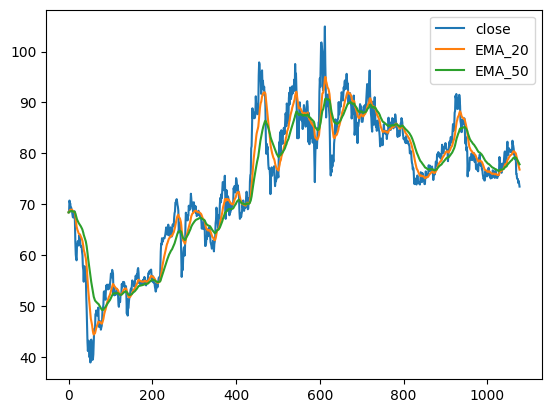

In [76]:
plt.figure(figsize=(18, 6))
df[['close','EMA_20' , 'EMA_50']].plot()
plt.show()

In [78]:
rmse_sma = np.sqrt(mean_squared_error(df['EMA_20'], df['close']))  # Tính RMSE
mae_sma = mean_absolute_error(df['EMA_20'], df['close'] )  # Tính MAE

# In ra kết quả
print(f"Root Mean Squared Error (RMSE) of EMA_20: {rmse_sma}")
print(f"Mean Absolute Error (MAE) of EMA_20: {mae_sma}")

Root Mean Squared Error (RMSE) of EMA_20: 3.2005790557277463
Mean Absolute Error (MAE) of EMA_20: 2.3156116968155094


In [79]:
rmse_sma = np.sqrt(mean_squared_error(df['EMA_50'], df['close']))  # Tính RMSE
mae_sma = mean_absolute_error(df['EMA_50'], df['close'] )  # Tính MAE

# In ra kết quả
print(f"Root Mean Squared Error (RMSE) of EMA_50: {rmse_sma}")
print(f"Mean Absolute Error (MAE) of EMA_50: {mae_sma}")

Root Mean Squared Error (RMSE) of EMA_50: 4.608337997840487
Mean Absolute Error (MAE) of EMA_50: 3.3823865355384077


# LSTM

In [150]:
data = df[['time' , 'close']]
close = data[['close']].values


In [176]:

train_size= int(close.size *0.8)
train_data = close[:train_size]
test_data = close[train_size:]
sc = MinMaxScaler(feature_range=(0,1))
train_data = sc.fit_transform(train_data)
block_size = 5
X_train = []
y_train = []
for i in range(block_size, train_size):
    X_train.append(train_data[i-block_size:i , 0])
    y_train.append(train_data[i , 0])

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50 , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50 , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dense(units=1))

In [153]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [154]:
model.fit(X_train , y_train , epochs=100 , batch_size=5 , verbose = 2)

Epoch 1/100
172/172 - 13s - loss: 0.1141 - 13s/epoch - 77ms/step
Epoch 2/100
172/172 - 3s - loss: 0.0516 - 3s/epoch - 16ms/step
Epoch 3/100
172/172 - 3s - loss: 0.0458 - 3s/epoch - 15ms/step
Epoch 4/100
172/172 - 3s - loss: 0.0453 - 3s/epoch - 15ms/step
Epoch 5/100
172/172 - 3s - loss: 0.0464 - 3s/epoch - 18ms/step
Epoch 6/100
172/172 - 3s - loss: 0.0418 - 3s/epoch - 20ms/step
Epoch 7/100
172/172 - 3s - loss: 0.0419 - 3s/epoch - 15ms/step
Epoch 8/100
172/172 - 3s - loss: 0.0433 - 3s/epoch - 15ms/step
Epoch 9/100
172/172 - 3s - loss: 0.0414 - 3s/epoch - 15ms/step
Epoch 10/100
172/172 - 3s - loss: 0.0427 - 3s/epoch - 20ms/step
Epoch 11/100
172/172 - 4s - loss: 0.0431 - 4s/epoch - 23ms/step
Epoch 12/100
172/172 - 3s - loss: 0.0416 - 3s/epoch - 15ms/step
Epoch 13/100
172/172 - 3s - loss: 0.0407 - 3s/epoch - 16ms/step
Epoch 14/100
172/172 - 3s - loss: 0.0372 - 3s/epoch - 16ms/step
Epoch 15/100
172/172 - 3s - loss: 0.0383 - 3s/epoch - 20ms/step
Epoch 16/100
172/172 - 3s - loss: 0.0401 - 3s/e

In [155]:
y_train_inver = sc.inverse_transform(y_train)

In [156]:
y_train_inver

array([[ 68.878],
       [ 69.384],
       [ 68.95 ],
       [ 68.661],
       [ 68.01 ],
       [ 67.503],
       [ 67.431],
       [ 67.575],
       [ 68.661],
       [ 68.661],
       [ 66.563],
       [ 62.583],
       [ 60.196],
       [ 59.328],
       [ 59.038],
       [ 62.149],
       [ 62.222],
       [ 62.8  ],
       [ 61.932],
       [ 62.222],
       [ 63.307],
       [ 64.03 ],
       [ 63.162],
       [ 62.222],
       [ 61.715],
       [ 61.715],
       [ 61.787],
       [ 60.702],
       [ 60.051],
       [ 57.808],
       [ 57.157],
       [ 54.842],
       [ 57.157],
       [ 57.88 ],
       [ 56.506],
       [ 56.506],
       [ 56.072],
       [ 52.165],
       [ 49.56 ],
       [ 46.16 ],
       [ 42.976],
       [ 41.24 ],
       [ 42.904],
       [ 43.266],
       [ 41.963],
       [ 40.01 ],
       [ 41.891],
       [ 38.997],
       [ 40.661],
       [ 43.483],
       [ 42.47 ],
       [ 42.108],
       [ 39.503],
       [ 39.648],
       [ 40.589],
       [ 4

In [133]:
y_train_pre = model.predict(X_train)

27/27 [==============================] - 0s 10ms/step


In [193]:
y_train_1 = sc.inverse_transform(y_train)

In [ ]:
y_train_1

In [161]:
y_train_predict = sc.inverse_transform(y_train_pre)

In [163]:
y_train_predict[:10]

array([[70.83844 ],
       [69.863075],
       [70.18906 ],
       [69.83781 ],
       [69.51784 ],
       [68.91039 ],
       [68.43314 ],
       [68.2697  ],
       [68.33036 ],
       [69.17633 ]], dtype=float32)

In [164]:
dftrain = data[block_size : train_size]
dftrain.loc[: , 'predict'] = y_train_predict

<ipython-input-164-0d251f5ad25e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain.loc[: , 'predict'] = y_train_predict


In [ ]:
dftrain

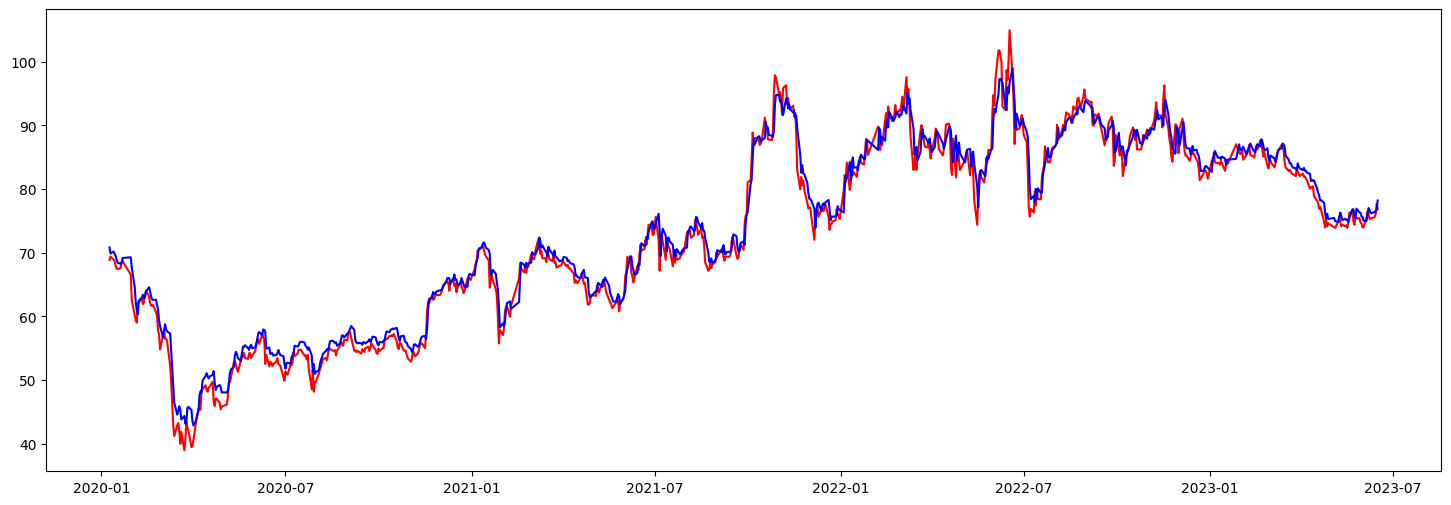

In [169]:

plt.figure(figsize=(18, 6))
plt.plot(dftrain['time'],dftrain['close'] , color = 'red' , label = 'Close')
plt.plot(dftrain['time'],dftrain['predict'] , color = 'blue' , label = 'predict' )
plt.show()

In [200]:
print('Độ phù hợp r_2:{}'.format(r2_score(y_train_1 , y_train_predict)))
print("Sai số tuyệt đối trung bình : {}".format(mean_absolute_error(y_train_1 , y_train_predict)))
print("Phần trăm sai số tuyệt đối trung bình: {}".format(mean_absolute_percentage_error(y_train_1 , y_train_predict)))

Độ phù hợp r_2:0.9809714321059219
Sai số tuyệt đối trung bình : 1.4930382797259019
Phần trăm sai số tuyệt đối trung bình: 0.02168762418051984


# Mô hình Bidirectional LSTM

In [246]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model_bilstm.add(Bidirectional(LSTM(50, return_sequences=False)))
model_bilstm.add(Dense(25))
model_bilstm.add(Dense(1))

In [247]:
model_bilstm.compile(optimizer='adam', loss='mean_absolute_error')
model_bilstm.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 5, 100)            20800     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 25)                2525      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 83751 (327.15 KB)
Trainable params: 83751 (327.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [248]:
model_bilstm.fit(X_train , y_train , epochs = 50 , batch_size = 5 , verbose = 2)

Epoch 1/50
172/172 - 11s - loss: 0.0646 - 11s/epoch - 66ms/step
Epoch 2/50
172/172 - 2s - loss: 0.0307 - 2s/epoch - 11ms/step
Epoch 3/50
172/172 - 2s - loss: 0.0293 - 2s/epoch - 10ms/step
Epoch 4/50
172/172 - 2s - loss: 0.0297 - 2s/epoch - 11ms/step
Epoch 5/50
172/172 - 2s - loss: 0.0291 - 2s/epoch - 11ms/step
Epoch 6/50
172/172 - 2s - loss: 0.0290 - 2s/epoch - 14ms/step
Epoch 7/50
172/172 - 3s - loss: 0.0298 - 3s/epoch - 16ms/step
Epoch 8/50
172/172 - 2s - loss: 0.0285 - 2s/epoch - 11ms/step
Epoch 9/50
172/172 - 2s - loss: 0.0322 - 2s/epoch - 10ms/step
Epoch 10/50
172/172 - 2s - loss: 0.0254 - 2s/epoch - 11ms/step
Epoch 11/50
172/172 - 2s - loss: 0.0263 - 2s/epoch - 11ms/step
Epoch 12/50
172/172 - 2s - loss: 0.0251 - 2s/epoch - 11ms/step
Epoch 13/50
172/172 - 3s - loss: 0.0232 - 3s/epoch - 15ms/step
Epoch 14/50
172/172 - 3s - loss: 0.0244 - 3s/epoch - 16ms/step
Epoch 15/50
172/172 - 2s - loss: 0.0229 - 2s/epoch - 10ms/step
Epoch 16/50
172/172 - 2s - loss: 0.0239 - 2s/epoch - 11ms/step

In [249]:
y_predict_bilstm = model_bilstm.predict(X_train)

27/27 [==============================] - 2s 6ms/step


In [250]:
y_train_bilstm = sc.inverse_transform(y_train)

In [251]:
y_predict_bilstm = sc.inverse_transform(y_predict_bilstm)

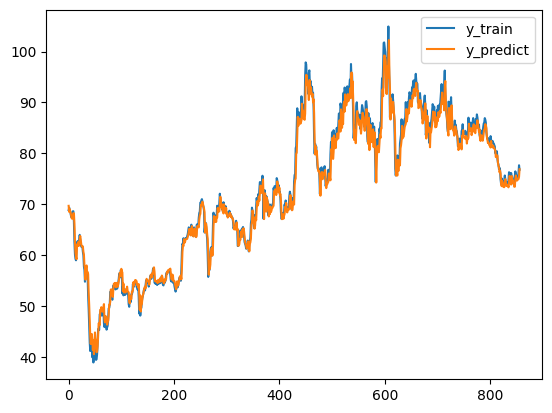

In [252]:
plt.plot(y_train_bilstm , label = 'y_train')
plt.plot(y_predict_bilstm , label = 'y_predict')
plt.legend()
plt.show()

In [209]:
print('Độ phù hợp r_2:{}'.format(r2_score(y_train_bilstm , y_predict_bilstm)))
print("Sai số tuyệt đối trung bình : {}".format(mean_absolute_error(y_train_bilstm , y_predict_bilstm)))
print("Phần trăm sai số tuyệt đối trung bình: {}".format(mean_absolute_percentage_error(y_train_bilstm , y_predict_bilstm)))

Độ phù hợp r_2:0.9798098185493851
Sai số tuyệt đối trung bình : 1.5557330521680375
Phần trăm sai số tuyệt đối trung bình: 0.02132899974331687


# Mô hình GRU Seq2Seq VAE

In [210]:

model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(50, return_sequences=False))
model_gru.add(RepeatVector(X_train.shape[1]))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(TimeDistributed(Dense(1)))

In [211]:
model_gru.compile(optimizer='adam', loss='mean_absolute_error')
model_gru.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 5, 50)             7950      
                                                                 
 gru_6 (GRU)                 (None, 50)                15300     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 5, 50)             0         
 tor)                                                            
                                                                 
 gru_7 (GRU)                 (None, 5, 50)             15300     
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 1)              51        
 stributed)                                                      
                                                                 
Total params: 38601 (150.79 KB)
Trainable params: 3860

In [212]:
model_gru.fit(X_train , y_train , batch_size = 5 , epochs = 50 , verbose = 1)

Epoch 1/50
172/172 [==============================] - 10s 15ms/step - loss: 0.0694
Epoch 2/50
172/172 [==============================] - 2s 13ms/step - loss: 0.0320
Epoch 3/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0277
Epoch 4/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0294
Epoch 5/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0266
Epoch 6/50
172/172 [==============================] - 2s 14ms/step - loss: 0.0302
Epoch 7/50
172/172 [==============================] - 3s 15ms/step - loss: 0.0256
Epoch 8/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0240
Epoch 9/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0230
Epoch 10/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0254
Epoch 11/50
172/172 [==============================] - 2s 12ms/step - loss: 0.0214
Epoch 12/50
172/172 [==============================] - 2s 13ms/step - loss: 0.0228
Epoch 13/50


In [213]:
y_pre_gru = model_gru.predict(X_train)

27/27 [==============================] - 1s 5ms/step


In [214]:
y_train_gru = sc.inverse_transform(y_train)

In [220]:
y_pre_gru = y_pre_gru.reshape(-1 , 1)

In [ ]:
y_train_gru

In [221]:

y_pre_gru = sc.inverse_transform(y_pre_gru)

In [224]:
print('Độ phù hợp r_2:{}'.format(r2_score(y_train_gru, y_pre_gru[:len(y_train_gru)])))
print("Sai số tuyệt đối trung bình : {}".format(mean_absolute_error(y_train_gru , y_pre_gru[:len(y_train_gru)])))
print("Phần trăm sai số tuyệt đối trung bình: {}".format(mean_absolute_percentage_error(y_train_gru , y_pre_gru[:len(y_train_gru)])))

Độ phù hợp r_2:-2.3698044004646897
Sai số tuyệt đối trung bình : 23.700033787766305
Phần trăm sai số tuyệt đối trung bình: 0.3106375102428217


# Mô hình Dilated Convolutional Neural Network Seq2Seq

In [237]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu' , padding = 'same'))
# Adjust the pool size or remove the MaxPooling1D layer if it's not crucial
model_cnn.add(MaxPooling1D(pool_size=1))  # Changed pool_size to 1
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50))
model_cnn.add(Dense(1))

In [238]:
model_cnn.compile(optimizer='adam', loss='mean_absolute_error')
model_cnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 3, 64)             256       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 1, 64)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 128)            24704     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 1, 128)          

In [239]:
model_cnn.fit(X_train , y_train , batch_size = 5 , epochs = 50 , verbose = 1)

Epoch 1/50
172/172 [==============================] - 2s 4ms/step - loss: 0.0771
Epoch 2/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0571
Epoch 3/50
172/172 [==============================] - 0s 2ms/step - loss: 0.0512
Epoch 4/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0516
Epoch 5/50
172/172 [==============================] - 0s 2ms/step - loss: 0.0490
Epoch 6/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0439
Epoch 7/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0501
Epoch 8/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0452
Epoch 9/50
172/172 [==============================] - 0s 2ms/step - loss: 0.0470
Epoch 10/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0461
Epoch 11/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0437
Epoch 12/50
172/172 [==============================] - 0s 3ms/step - loss: 0.0445
Epoch 13/50
172/172 [====

In [240]:
y_pre_cnn = model_cnn.predict(X_train)
y_pre_cnn = sc.inverse_transform(y_pre_cnn)

27/27 [==============================] - 0s 2ms/step


In [241]:
y_train_cnn = sc.inverse_transform(y_train)

In [242]:
print('Độ phù hợp r_2:{}'.format(r2_score(y_train_cnn , y_pre_cnn)))
print("Sai số tuyệt đối trung bình : {}".format(mean_absolute_error(y_train_cnn , y_pre_cnn)))
print("Phần trăm sai số tuyệt đối trung bình: {}".format(mean_absolute_percentage_error(y_train_cnn , y_pre_cnn)))

Độ phù hợp r_2:0.9229818822257434
Sai số tuyệt đối trung bình : 3.0980879741299248
Phần trăm sai số tuyệt đối trung bình: 0.0403020634040652


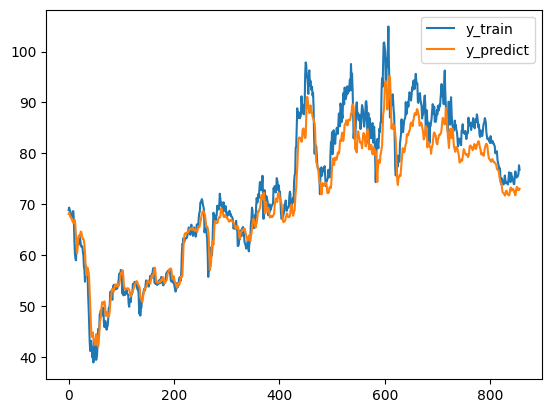

In [243]:
plt.plot(y_train_cnn , label = 'y_train')
plt.plot(y_pre_cnn , label = 'y_predict')
plt.legend()
plt.show()

# Tổng kết

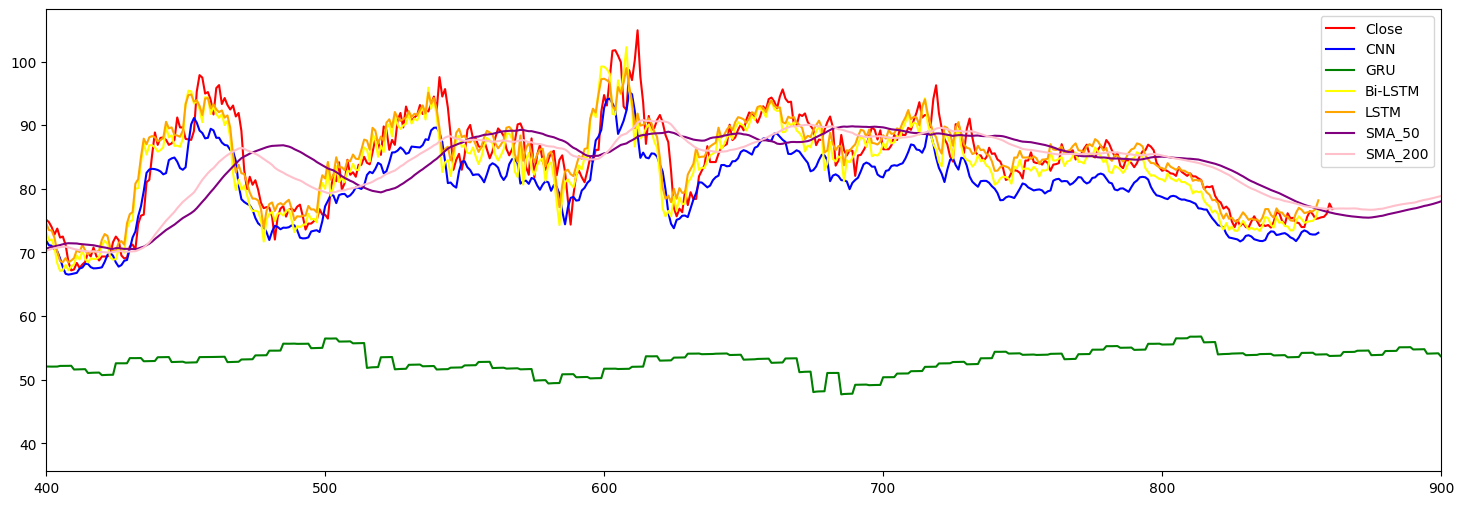

In [256]:
plt.figure(figsize=(18, 6))
plt.plot(dftrain['close'] , color = 'red' , label = 'Close')
plt.plot(y_pre_cnn , color = 'blue' , label = 'CNN' )
plt.plot(y_pre_gru , color = 'green' , label = 'GRU')
plt.plot(y_predict_bilstm , color = 'yellow' , label = 'Bi-LSTM')
plt.plot(y_train_predict , color = 'orange' , label = 'LSTM')
plt.plot(df['50 day'] , color = 'purple' , label = 'SMA_50')
plt.plot(df['EMA_50'] , color = 'pink' , label = 'SMA_200')
plt.xlim(400 , 900)
plt.legend()
plt.show()